In [1]:
from py_virion_data.deposit import deposit
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

### **Fetch Zoonotic Families**
Extract virus families ending with 'viridae' and with transmission containing "zoonosis".
Store them as a lowercase unique list.

In [2]:
#  Pull Zoonotic Families from ViralZone
url = "https://viralzone.expasy.org/678"

# Read all tables from the page
tables = pd.read_html(url)
print(f"Found {len(tables)} tables")

# Main virus table (Table 1)
virus_table = tables[1]

# Drop rows where 'Genus, Family' or 'Transmission' is missing
virus_table = virus_table.dropna(subset=['Genus, Family', 'Transmission'])

# Extract the family name from 'Genus, Family'
virus_table['Family'] = virus_table['Genus, Family'].apply(lambda x: str(x).split(',')[-1].strip())

# Filter for families ending with 'viridae' and transmission mentioning 'zoonosis'
zoonotic_families = virus_table[
    (virus_table['Family'].str.lower().str.endswith('viridae')) &
    (virus_table['Transmission'].str.lower().str.contains('zoonosis'))
]['Family']

# Convert to lowercase and get unique families
zoonotic_families_list = sorted(zoonotic_families.str.lower().unique())

print("Unique zoonotic virus families from ViralZone (lowercase):")
print(zoonotic_families_list)

# Export to CSV
pd.DataFrame(zoonotic_families_list, columns=['Family']).to_csv("viralzone_zoonotic_families.csv", index=False)


Found 127 tables
Unique zoonotic virus families from ViralZone (lowercase):
['arenaviridae', 'coronaviridae', 'filoviridae', 'flaviviridae', 'herpesviridae', 'nairoviridae', 'orthomyxoviridae', 'paramyxoviridae', 'phenuiviridae', 'picornaviridae', 'poxviridae', 'reoviridae', 'retroviridae', 'rhabdoviridae', 'togaviridae']


C:\Users\sowmy\AppData\Local\Temp\ipykernel_20364\426835226.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virus_table['Family'] = virus_table['Genus, Family'].apply(lambda x: str(x).split(',')[-1].strip())


### **Zoonotic Virus–Host Data Processing**

This section performs the following steps:

1. Initialize the Virion Data Handler  
2. Load DataFrames 
3. Merge DataFrames  
4. Identify Human and Non-Human Hosts
5. Clean and Select Key Columns 
6. Summary

In [3]:
# Initialize the virion data handler
virion = deposit()

# Load the three required dataframes
df_host = virion.get_latest_dataframe("taxonomy_host")
df_virus = virion.get_latest_dataframe("taxonomy_virus")
df_edges = virion.get_latest_dataframe("edgelist")

# Display the first few rows of each dataframe
print("taxonomy_host.csv")
display(df_host.head())

print("taxonomy_virus.csv")
display(df_virus.head())

print("edgelist.csv")
display(df_edges.head())

[17282863, 17230529, 17128513, 17082447, 17065372, 16943880, 16809687, 16741651, 16622910, 16582436, 16423191, 16422566, 15896981, 15833251, 15832919, 15831977, 15793837, 15793785, 15779206, 15733485, 15732796, 15723628, 15723072, 15692263, 15677843]
taxonomy_host.csv


,HostTaxID,Host,HostGenus,HostFamily,HostOrder,HostClass,HostNCBIResolved
0,8830,NaN,NaN,anatidae,anseriformes,aves,True
1,57775,NaN,acanthemblemaria,chaenopsidae,blenniiformes,actinopteri,True
2,9443,NaN,NaN,NaN,primates,mammalia,True
3,8487,NaN,NaN,testudinidae,testudines,NaN,True
4,8782,NaN,NaN,NaN,NaN,aves,True


taxonomy_virus.csv


,VirusTaxID,Virus,VirusGenus,VirusFamily,VirusOrder,VirusClass,VirusNCBIResolved,ICTVRatified,Database
0,2169685,aalivirus apekidu,aalivirus,picornaviridae,picornavirales,pisoniviricetes,True,True,GenBank
1,2807758,aalivirus sp.,aalivirus,picornaviridae,picornavirales,pisoniviricetes,True,False,GenBank
2,2951534,abudefduf bengalensis circovirus,circovirus,circoviridae,cirlivirales,arfiviricetes,True,False,GenBank
3,2563836,academ virus,orthohantavirus,hantaviridae,elliovirales,bunyaviricetes,True,False,GenBank
4,3425966,acamarivirus apogeeis,acamarivirus,mahapunaviridae,saturnivirales,arfiviricetes,True,True,GenBank


edgelist.csv


,HostTaxID,VirusTaxID,AssocID
0,10009,11082,818281
1,10009,11083,"818282, 818283, 818284"
2,10009,1821749,818273
3,10009,2748762,"818275, 818276"
4,10009,28875,818285


In [4]:
# Merge Step 1: Join hosts with edgelist on HostTaxID
merged_host_edges = pd.merge(
    df_edges,
    df_host,
    on="HostTaxID",
    how="left"
)

# Merge Step 2: Join the above with viruses on VirusTaxID
merged_full = pd.merge(
    merged_host_edges,
    df_virus,
    on="VirusTaxID",
    how="left",
    suffixes=("_Host", "_Virus")  # distinguish columns clearly
)

# Identify human and non-human hosts
HUMAN_TAXID = 9606 

# step 1: Get all viruses that infect humans
human_viruses = merged_full[merged_full["HostTaxID"] == HUMAN_TAXID]["VirusTaxID"].unique()

# Step 2: Get all non-human host records for those same viruses
zoonotic_records = merged_full[
    (merged_full["VirusTaxID"].isin(human_viruses)) &
    (merged_full["HostTaxID"] != HUMAN_TAXID)
]

# Step 3: Clean up the result (select key columns)
zoonotic_records = zoonotic_records[
    [
        "VirusTaxID", "Virus", "VirusFamily", "VirusOrder", "VirusClass",
        "HostTaxID", "Host", "HostFamily", "HostOrder", "HostClass",
        "AssocID"
    ]
].drop_duplicates()

# Print total number of zoonotic associations
print(f"\n Total number of zoonotic host–virus associations: {len(zoonotic_records):,}")

# Display sample records
print("\n Sample Zoonotic Virus–Host Pairs")
display(zoonotic_records.head(5))



 Total number of zoonotic host–virus associations: 12,623

 Sample Zoonotic Virus–Host Pairs


,VirusTaxID,Virus,VirusFamily,VirusOrder,VirusClass,HostTaxID,Host,HostFamily,HostOrder,HostClass,AssocID
0,11082,orthoflavivirus nilense,flaviviridae,amarillovirales,flasuviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,818281
1,11082,west nile virus,flaviviridae,amarillovirales,flasuviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,818281
2,11083,orthoflavivirus powassanense,flaviviridae,amarillovirales,flasuviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,"818282, 818283, 818284"
3,1821749,cardiovirus rueckerti,picornaviridae,picornavirales,pisoniviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,818273
4,2748762,coltivirus dermacentoris,spinareoviridae,reovirales,resentoviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,"818275, 818276"


### **Building and Analyzing the Pathogen Sharing Network**

In [9]:
# Filter your zoonotic_records using the fetched families

# Ensure 'VirusFamily' column exists and drop rows with null family
zoonotic_records = zoonotic_records.dropna(subset=['VirusFamily']).copy()

# Make the ViralZone list lowercase for comparison
zoonotic_families_lower = [fam.lower() for fam in zoonotic_families_list]

# Filter only rows whose VirusFamily is in the zoonotic families list
zoonotic_records_filtered = zoonotic_records[
    zoonotic_records["VirusFamily"].str.strip().str.lower().isin(zoonotic_families_lower)
].copy()

print(f"Total rows after filtering with ViralZone zoonotic families: {len(zoonotic_records_filtered):,}")

# Display counts per virus family
zoonotic_family_counts = (
    zoonotic_records_filtered["VirusFamily"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "VirusFamily", "VirusFamily": "OccurrenceCount"})
    .sort_values(by="OccurrenceCount", ascending=False)
)

display(zoonotic_family_counts)



Total rows after filtering with ViralZone zoonotic families: 9,017


,OccurrenceCount,count
3,togaviridae,855
5,rhabdoviridae,653
6,retroviridae,613
14,reoviridae,83
8,poxviridae,363
4,picornaviridae,754
9,phenuiviridae,178
2,paramyxoviridae,1143
1,orthomyxoviridae,1188
11,nairoviridae,130


In [11]:

# Print basic info about the dataframe
print("Zoonotic Records Info:")
zoonotic_records_filtered.info()

# Print missing values per column
print("\nMissing Values:")
print(zoonotic_records_filtered.isnull().sum())


Zoonotic Records Info:
<class 'pandas.core.frame.DataFrame'>
Index: 9017 entries, 0 to 36155
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   VirusTaxID   9017 non-null   int64 
 1   Virus        9017 non-null   object
 2   VirusFamily  9017 non-null   object
 3   VirusOrder   9017 non-null   object
 4   VirusClass   9017 non-null   object
 5   HostTaxID    9017 non-null   int64 
 6   Host         8405 non-null   object
 7   HostFamily   8868 non-null   object
 8   HostOrder    9001 non-null   object
 9   HostClass    8990 non-null   object
 10  AssocID      9017 non-null   object
dtypes: int64(2), object(9)
memory usage: 845.3+ KB

Missing Values:
VirusTaxID       0
Virus            0
VirusFamily      0
VirusOrder       0
VirusClass       0
HostTaxID        0
Host           612
HostFamily     149
HostOrder       16
HostClass       27
AssocID          0
dtype: int64


In [12]:
# Fill missing host info
zoonotic_records_filtered['Host'] = zoonotic_records_filtered['Host'].fillna('Unknown')
zoonotic_records_filtered['HostFamily'] = zoonotic_records_filtered['HostFamily'].fillna('Unknown')
zoonotic_records_filtered['HostOrder'] = zoonotic_records_filtered['HostOrder'].fillna('Unknown')
zoonotic_records_filtered['HostClass'] = zoonotic_records_filtered['HostClass'].fillna('Unknown')

# Print the missing values again
print("Missing Values After Cleaning")
print(zoonotic_records_filtered.isnull().sum())



Missing Values After Cleaning
VirusTaxID     0
Virus          0
VirusFamily    0
VirusOrder     0
VirusClass     0
HostTaxID      0
Host           0
HostFamily     0
HostOrder      0
HostClass      0
AssocID        0
dtype: int64


In [13]:
# Export filtered zoonotic_records to CSV 

if zoonotic_records_filtered.empty:
    print("No zoonotic records available. Cannot save file.")
else:
    # Define output filename
    output_filename = "ncbi_viral_metadata.csv"
    
    # Save the filtered DataFrame to CSV
    zoonotic_records_filtered.to_csv(output_filename, index=False)
    
    print(f"Total {len(zoonotic_records_filtered):,} zoonotic records have been saved to '{output_filename}'")

    
    # Display the first few rows for preview
    print("\nData Preview:")
    display(zoonotic_records_filtered.head())


Total 9,017 zoonotic records have been saved to 'ncbi_viral_metadata.csv'

Data Preview:


,VirusTaxID,Virus,VirusFamily,VirusOrder,VirusClass,HostTaxID,Host,HostFamily,HostOrder,HostClass,AssocID
0,11082,orthoflavivirus nilense,flaviviridae,amarillovirales,flasuviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,818281
1,11082,west nile virus,flaviviridae,amarillovirales,flasuviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,818281
2,11083,orthoflavivirus powassanense,flaviviridae,amarillovirales,flasuviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,"818282, 818283, 818284"
3,1821749,cardiovirus rueckerti,picornaviridae,picornavirales,pisoniviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,818273
5,28875,rotavirus a,reoviridae,reovirales,resentoviricetes,10009,tamiasciurus hudsonicus,sciuridae,rodentia,mammalia,818285


C:\Users\sowmy\AppData\Local\Temp\ipykernel_15216\2435199560.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=family_counts.index, y=family_counts.values, palette='viridis')


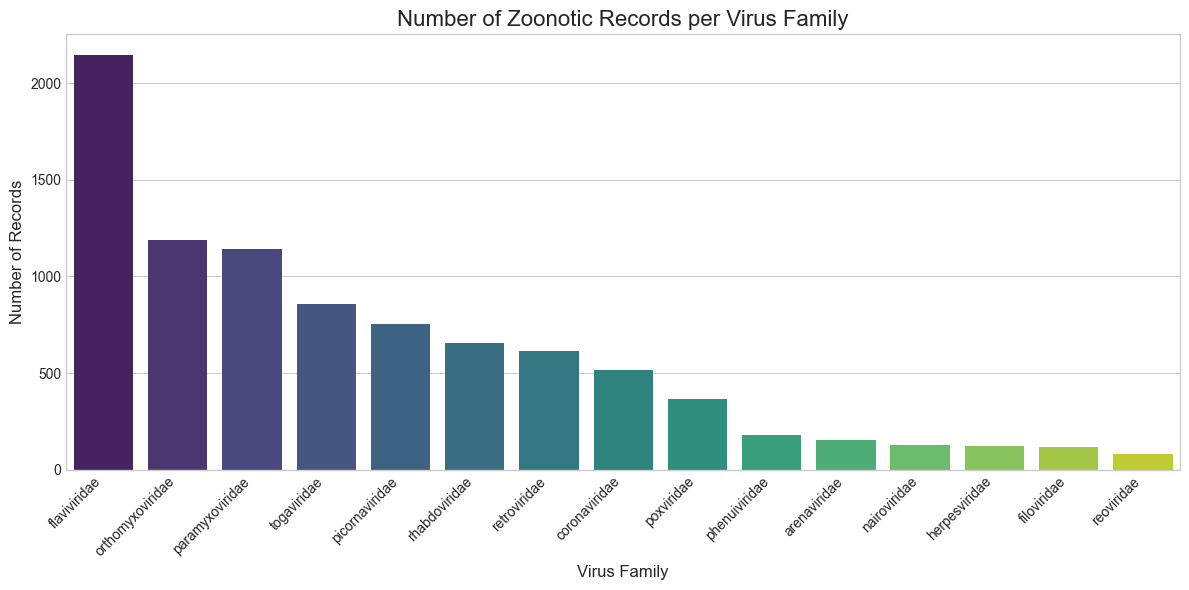

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of records per virus family
family_counts = zoonotic_records_filtered['VirusFamily'].value_counts()

# Plot the distribution
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

sns.barplot(x=family_counts.index, y=family_counts.values, palette='viridis')

plt.title('Number of Zoonotic Records per Virus Family', fontsize=16)
plt.xlabel('Virus Family', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45, ha='right')  # rotate labels for readability
plt.tight_layout()
plt.show()




C:\Users\sowmy\AppData\Local\Temp\ipykernel_15216\903121949.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=host_counts_original.index, x=host_counts_original.values, palette='plasma', orient='h')


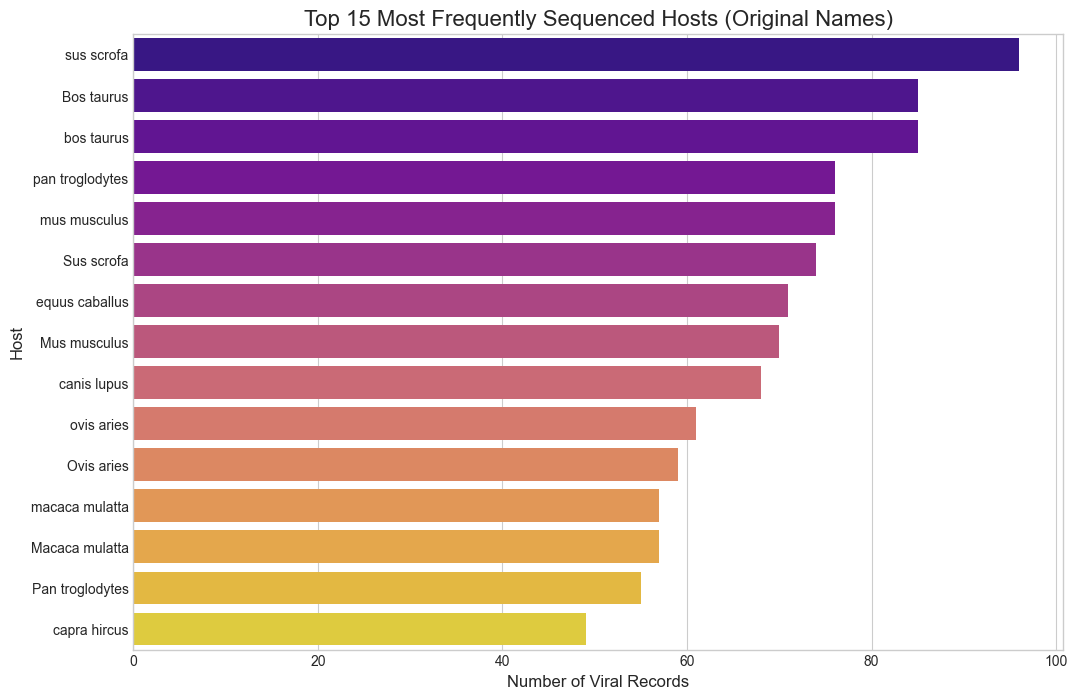

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude non-informative host names
top_hosts_original = zoonotic_records_filtered[~zoonotic_records_filtered['Host'].isin(['Unknown', 'Nan', ''])].copy()

plt.figure(figsize=(12, 8))

# Get value counts of the top 15 original hosts
host_counts_original = top_hosts_original['Host'].value_counts().nlargest(15)

# Create horizontal bar plot
sns.barplot(y=host_counts_original.index, x=host_counts_original.values, palette='plasma', orient='h')

plt.title('Top 15 Most Frequently Sequenced Hosts (Original Names)', fontsize=16)
plt.xlabel('Number of Viral Records', fontsize=12)
plt.ylabel('Host', fontsize=12)
plt.show()


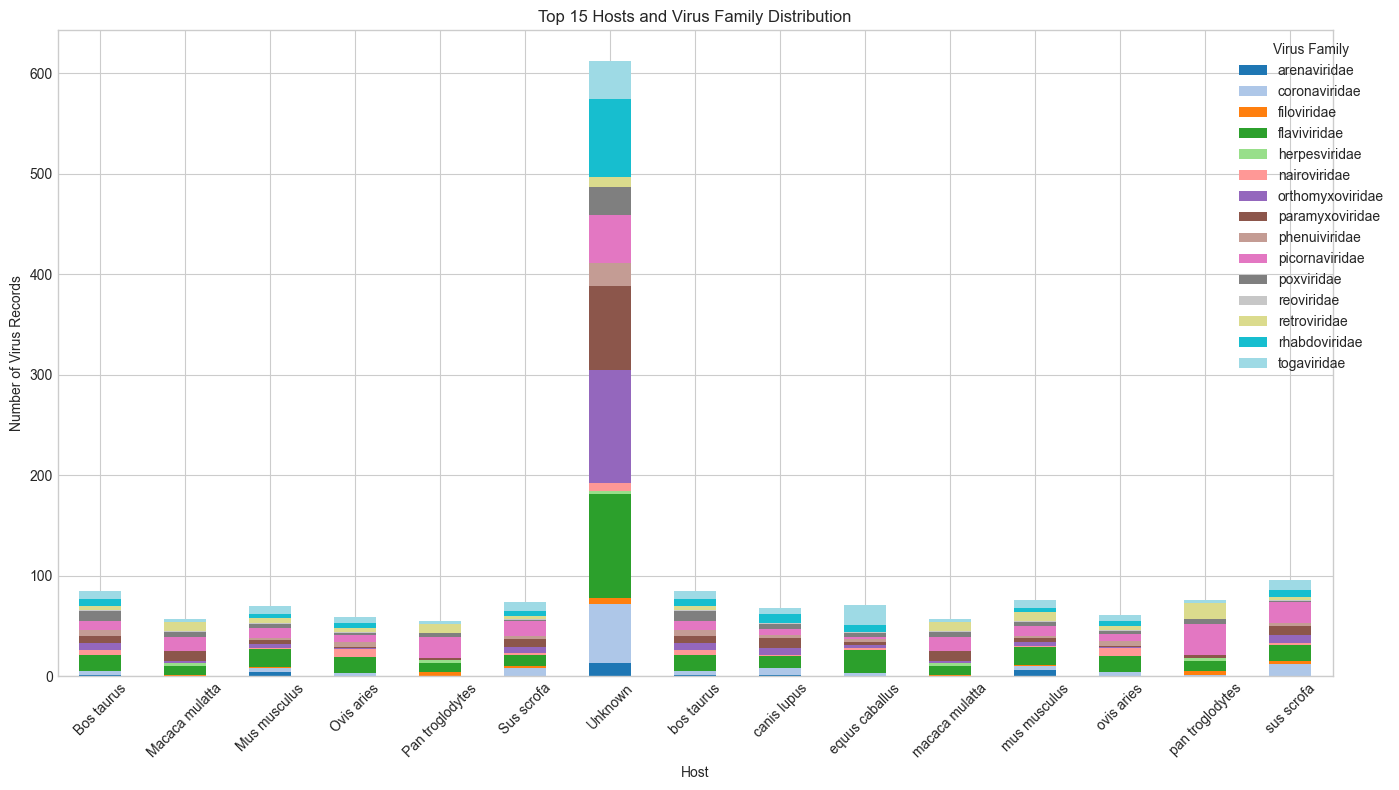

In [16]:

# Get top 15 hosts by number of records
top_hosts = zoonotic_records_filtered['Host'].value_counts().nlargest(15).index
subset = zoonotic_records_filtered[zoonotic_records_filtered['Host'].isin(top_hosts)]

# Pivot: hosts as rows, virus families as columns
pivot_df = subset.pivot_table(
    index='Host',
    columns='VirusFamily',
    values='Virus',
    aggfunc='count',
    fill_value=0
)

# Plot stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.ylabel('Number of Virus Records')
plt.title('Top 15 Hosts and Virus Family Distribution')
plt.xticks(rotation=45)
plt.legend(title='Virus Family', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()



In [17]:
# Clean host names
# Convert to Title Case and strip extra whitespace
zoonotic_records_filtered['host_clean'] = zoonotic_records_filtered['Host'].str.strip().str.title()

# Remove records with invalid host names
zoonotic_records_filtered = zoonotic_records_filtered[~zoonotic_records_filtered['host_clean'].isin(['Unknown', 'Nan', ''])].copy()

# Create dictionary mapping each host to its unique viruses
host_virus_dict = zoonotic_records_filtered.groupby('host_clean')['Virus'].apply(set).to_dict()

print(f"Processed data into a dictionary with {len(host_virus_dict)} unique hosts.")


Processed data into a dictionary with 1885 unique hosts.


### **Build the Network Graph**
This cell initializes the graph, adds nodes (hosts), and then adds edges based on shared viruses.

In [18]:
# Minimum number of shared viruses to create an edge
MIN_SHARED_VIRUSES = 1

# Initialize the full network graph
G_pathogen = nx.Graph()

# Add nodes
for host, viruses in host_virus_dict.items():
    G_pathogen.add_node(host, virus_count=len(viruses))

# Add edges based on shared viruses
hosts_list = list(host_virus_dict.keys())
for i in range(len(hosts_list)):
    for j in range(i + 1, len(hosts_list)):
        host1, host2 = hosts_list[i], hosts_list[j]
        shared_viruses = host_virus_dict[host1].intersection(host_virus_dict[host2])
        if len(shared_viruses) >= MIN_SHARED_VIRUSES:
            G_pathogen.add_edge(host1, host2, weight=len(shared_viruses))

print(f"Graph has {G_pathogen.number_of_nodes()} nodes and {G_pathogen.number_of_edges()} edges.")
print("Network Construction Complete!")

Graph has 1885 nodes and 279297 edges.
Network Construction Complete!


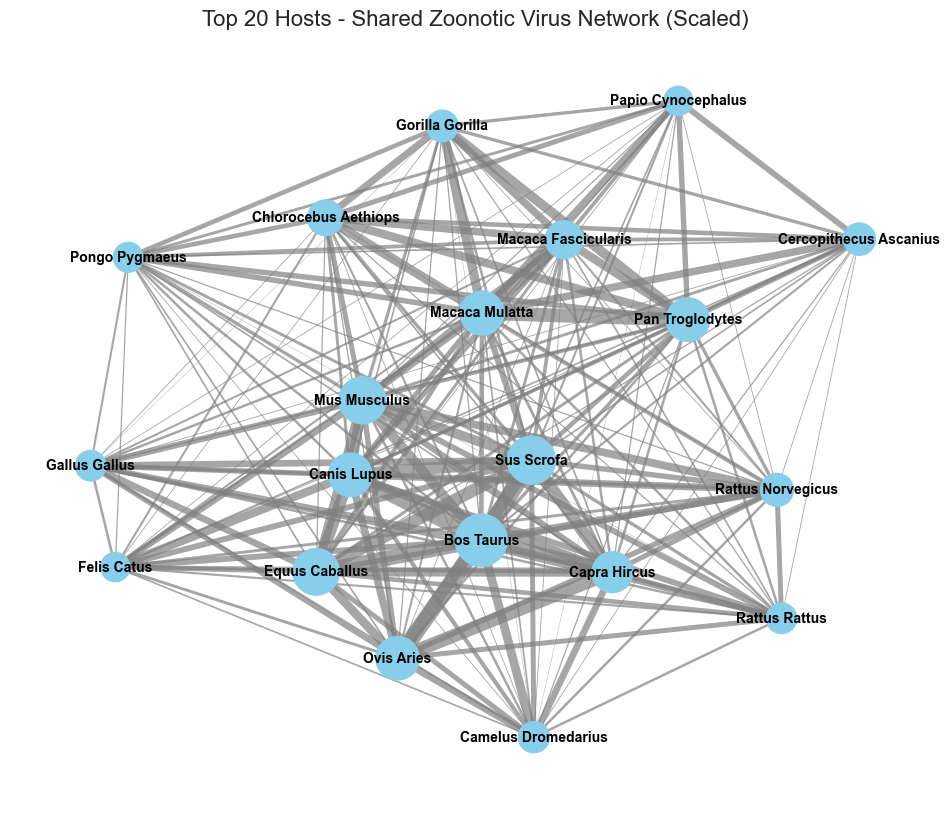

In [19]:
# Visualization using top 20 hosts by number of viruses
top_hosts = sorted(host_virus_dict, key=lambda x: len(host_virus_dict[x]), reverse=True)[:20]
G_sub = G_pathogen.subgraph(top_hosts)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_sub, k=0.5, seed=42)  # layout for spacing

# Node sizes proportional to number of viruses but scaled down
node_sizes = [G_sub.nodes[host]['virus_count']*20 for host in G_sub.nodes]

# Edge widths proportional to number of shared viruses but scaled down
edge_weights = [G_sub[u][v]['weight'] for u, v in G_sub.edges]
edge_widths = [w*0.3 for w in edge_weights]

# Draw nodes
nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color='skyblue')

# Draw edges
nx.draw_networkx_edges(G_sub, pos, width=edge_widths, alpha=0.7, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G_sub, pos, font_size=10, font_weight='bold')

plt.title('Top 20 Hosts - Shared Zoonotic Virus Network (Scaled)', fontsize=16)
plt.axis('off')
plt.show()



Top 30 Host Graph: 30 nodes, 435 edges


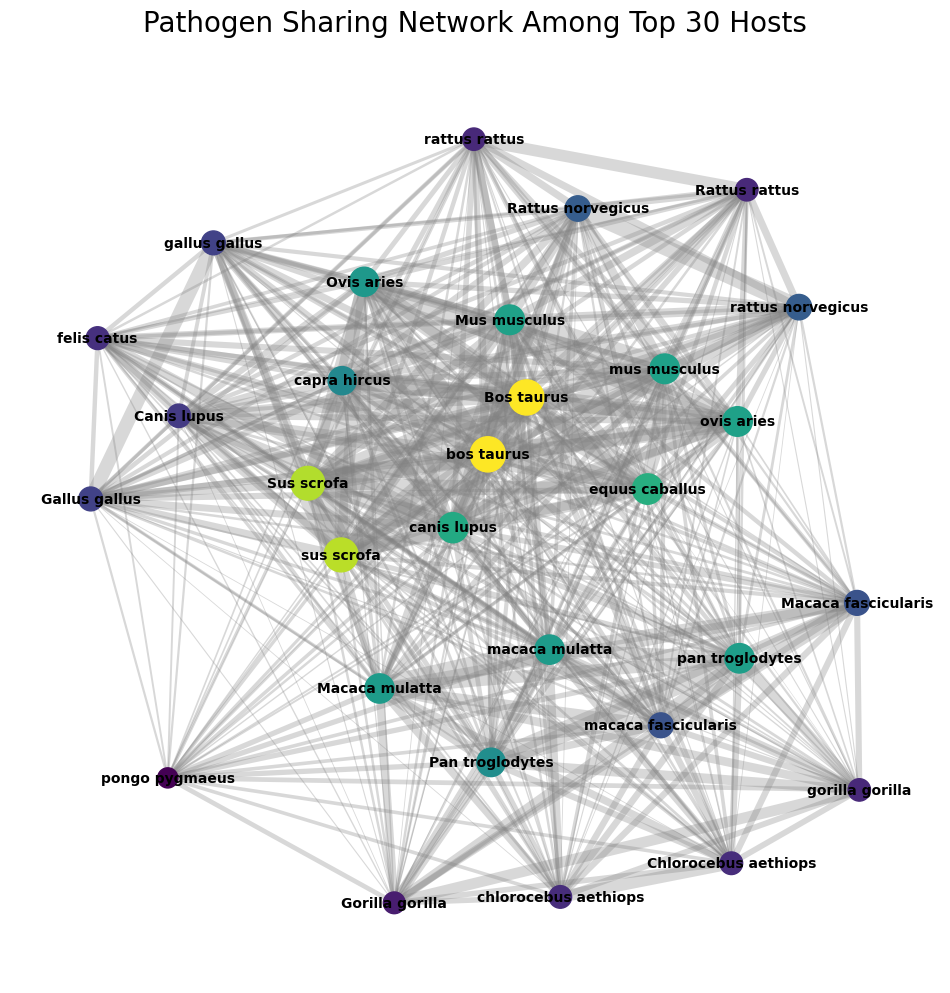

In [20]:
# Minimum number of shared viruses to create an edge
MIN_SHARED_VIRUSES = 1

# Select top 20 hosts by number of unique viruses
host_counts = zoonotic_records.groupby('Host')['Virus'].nunique().sort_values(ascending=False)
top_hosts = host_counts.head(30).index.tolist()

# Create a dictionary of only top hosts and their viruses
host_virus_dict_top = {host: set(zoonotic_records[zoonotic_records['Host'] == host]['Virus'].unique()) 
                       for host in top_hosts}

# Initialize the graph
G_top = nx.Graph()

# Add nodes
for host, viruses in host_virus_dict_top.items():
    G_top.add_node(host, virus_count=len(viruses))

# Add edges based on shared viruses
hosts_list = list(host_virus_dict_top.keys())
for i in range(len(hosts_list)):
    for j in range(i + 1, len(hosts_list)):
        host1, host2 = hosts_list[i], hosts_list[j]
        shared_viruses = host_virus_dict_top[host1].intersection(host_virus_dict_top[host2])
        if len(shared_viruses) >= MIN_SHARED_VIRUSES:
            G_top.add_edge(host1, host2, weight=len(shared_viruses))

print(f"Top 30 Host Graph: {G_top.number_of_nodes()} nodes, {G_top.number_of_edges()} edges")

#  Visualization 
plt.style.use('default')
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G_top, k=0.5, iterations=50, seed=42)

# Node sizes proportional to number of viruses
node_sizes = [d['virus_count'] * 5 + 50 for _, d in G_top.nodes(data=True)]

# Edge widths proportional to number of shared viruses
edge_widths = [d['weight'] * 0.2 for _, _, d in G_top.edges(data=True)]

# Draw edges
nx.draw_networkx_edges(G_top, pos, width=edge_widths, alpha=0.3, edge_color='grey')

# Draw nodes
nx.draw_networkx_nodes(G_top, pos, node_size=node_sizes, node_color=node_sizes, cmap=plt.cm.viridis)

# Draw labels
nx.draw_networkx_labels(G_top, pos, font_size=10, font_weight='bold')

# Final formatting
plt.title("Pathogen Sharing Network Among Top 30 Hosts", fontsize=20, pad=20)
plt.axis('off')
plt.show()


In [22]:
import pickle

# File to save the network graph
output_graph_file = "pathogen_sharing_network.gpickle"

try:
    # Save the graph object to a file using pickle
    with open(output_graph_file, 'wb') as f:
        pickle.dump(G_pathogen, f, pickle.HIGHEST_PROTOCOL)
    
    print(f"\n Successfully saved the full network graph to:")
    print(f" '{output_graph_file}'")

except Exception as e:
    print(f"\n An error occurred while saving the graph: {e}")



 Successfully saved the full network graph to:
 'pathogen_sharing_network.gpickle'


In [23]:
print("Calculating centrality measures for each host in the network...")

#  Degree Centrality 
degree_centrality = nx.degree_centrality(G_pathogen)

#  Betweenness Centrality 
betweenness_centrality = nx.betweenness_centrality(G_pathogen)

#  Eigenvector Centrality
try:
    eigenvector_centrality = nx.eigenvector_centrality(G_pathogen, max_iter=500)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector centrality did not converge, assigning zeros for all nodes.")
    eigenvector_centrality = {node: 0.0 for node in G_pathogen.nodes()}

# Combine into a DataFrame
centrality_df = pd.DataFrame({
    'Host': list(degree_centrality.keys()),
    'DegreeCentrality': list(degree_centrality.values()),
    'BetweennessCentrality': list(betweenness_centrality.values()),
    'EigenvectorCentrality': list(eigenvector_centrality.values())
})

print(" Successfully calculated centrality scores for hosts.")
display(centrality_df.head())


Calculating centrality measures for each host in the network...
 Successfully calculated centrality scores for hosts.


,Host,DegreeCentrality,BetweennessCentrality,EigenvectorCentrality
0,Acanthis Flammea,0.053079,0.000031,0.004322
1,Accipiter Cooperii,0.363057,0.000295,0.043421
2,Accipiter Gularis,0.145435,0.000000,0.015528
3,Accipiter Nisus,0.426221,0.000722,0.046781
4,Accipiter Striatus,0.363057,0.000295,0.043421


In [24]:
from sklearn.preprocessing import MinMaxScaler

# Create a copy of the centrality DataFrame
risk_df = centrality_df.copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Scale each centrality metric to 0–1 range
risk_df['Degree_scaled'] = scaler.fit_transform(risk_df[['DegreeCentrality']])
risk_df['Betweenness_scaled'] = scaler.fit_transform(risk_df[['BetweennessCentrality']])
risk_df['Eigenvector_scaled'] = scaler.fit_transform(risk_df[['EigenvectorCentrality']])

# Create a composite risk score (weights can be adjusted)
risk_df['CompositeRiskScore'] = (
    risk_df['Degree_scaled'] * 0.4 +
    risk_df['Betweenness_scaled'] * 0.4 +
    risk_df['Eigenvector_scaled'] * 0.2
)

# Sort hosts by the composite score in descending order
ranked_hosts_df = risk_df.sort_values(by='CompositeRiskScore', ascending=False)

print("Top 10 Highest-Risk Hosts (Data-Driven Ranking)")
display(ranked_hosts_df.head(10))


Top 10 Highest-Risk Hosts (Data-Driven Ranking)


,Host,DegreeCentrality,BetweennessCentrality,EigenvectorCentrality,Degree_scaled,Betweenness_scaled,Eigenvector_scaled,CompositeRiskScore
612,Equus Caballus,0.758493,0.041816,0.049230,0.957133,1.000000,0.949511,0.972755
238,Bos Taurus,0.792463,0.037013,0.051775,1.000000,0.885132,0.998598,0.953772
1719,Sus Scrofa,0.782378,0.035219,0.051848,0.987274,0.842229,1.000000,0.931801
1107,Mus Musculus,0.714437,0.034049,0.048563,0.901541,0.814249,0.936637,0.873643
327,Canis Lupus,0.750531,0.030644,0.048964,0.947086,0.732818,0.944384,0.860838
690,Gallus Gallus,0.687367,0.015451,0.051352,0.867381,0.369510,0.990442,0.692845
333,Capra Hircus,0.619958,0.017641,0.045366,0.782317,0.421859,0.874982,0.656667
323,Camelus Dromedarius,0.621019,0.014871,0.050165,0.783657,0.355637,0.967539,0.649226
1536,Rattus Norvegicus,0.572718,0.017375,0.046306,0.722706,0.415504,0.893117,0.633907
965,Macaca Mulatta,0.553079,0.013159,0.045793,0.697924,0.314689,0.883217,0.581688


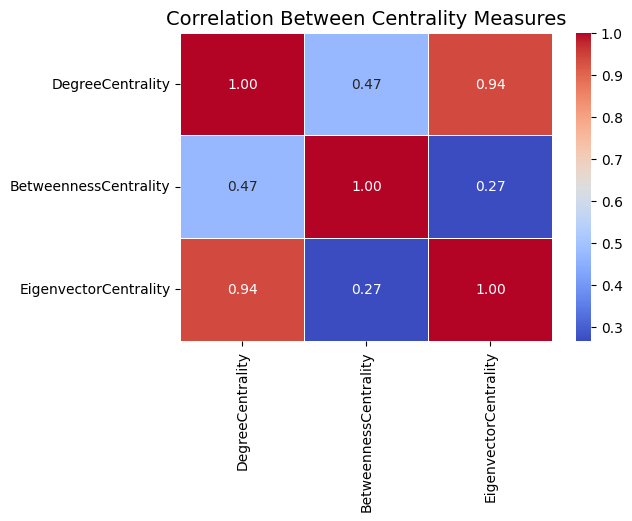

In [25]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    ranked_hosts_df[['DegreeCentrality', 'BetweennessCentrality', 'EigenvectorCentrality']].corr(),
    annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5
)
plt.title('Correlation Between Centrality Measures', fontsize=14)
plt.show()


### **High-Risk Hosts**
Create a data-driven list of high-risk hosts based on the composite score.

In [26]:
# Generate the high-risk host list from ranked hosts

RISK_SCORE_THRESHOLD = 0.1
TOP_N_HOSTS = 30

# Select hosts above the threshold
high_risk_species_list_from_data = ranked_hosts_df[
    ranked_hosts_df['CompositeRiskScore'] > RISK_SCORE_THRESHOLD
]['Host'].tolist()

# Fallback to top N if threshold gives too few
if len(high_risk_species_list_from_data) < 10:
    high_risk_species_list_from_data = ranked_hosts_df.head(TOP_N_HOSTS)['Host'].tolist()

# Convert to set for fast lookup
high_risk_species_set = set(high_risk_species_list_from_data)

# Print the count of highrisk hosts found
print(f"Generated a data-driven list of {len(high_risk_species_set)} high-risk hosts based on network centrality.")

# Print only top 30 hosts
top_to_show = high_risk_species_list_from_data[:TOP_N_HOSTS]
print(f"Top {len(top_to_show)} High-Risk Hosts: {top_to_show} ...")



Generated a data-driven list of 909 high-risk hosts based on network centrality.
Top 30 High-Risk Hosts: ['Equus Caballus', 'Bos Taurus', 'Sus Scrofa', 'Mus Musculus', 'Canis Lupus', 'Gallus Gallus', 'Capra Hircus', 'Camelus Dromedarius', 'Rattus Norvegicus', 'Macaca Mulatta', 'Procyon Lotor', 'Columba Livia', 'Ovis Aries', 'Macaca Fascicularis', 'Sturnus Vulgaris', 'Rousettus Leschenaultii', 'Vulpes Vulpes', 'Ursus Americanus', 'Passer Domesticus', 'Camelus Bactrianus', 'Panthera Leo', 'Artibeus Lituratus', 'Meleagris Gallopavo', 'Mephitis Mephitis', 'Equus Ferus', 'Equus Asinus', 'Anas Platyrhynchos', 'Macaca Sylvanus', 'Phasianus Colchicus', 'Panthera Tigris'] ...


In [28]:
import json

# Define the filename for the export
output_list_filename = "high_risk_species_list.json"

try:
    with open(output_list_filename, 'w') as f:
        # Write the Python list to a JSON file with indentation for readability
        json.dump(high_risk_species_list_from_data, f, indent=2)
    
    print(f" Successfully exported the list of {len(high_risk_species_list_from_data)} high-risk hosts to:")
    print(f" '{output_list_filename}'")

except NameError:
    print("ERROR: The variable 'high_risk_species_list_from_data' was not found.")
    print("Please make sure you have run the code that generates the ranked high-risk hosts first.")


 Successfully exported the list of 909 high-risk hosts to:
 'high_risk_species_list.json'


C:\Users\sowmy\AppData\Local\Temp\ipykernel_15216\2577044348.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


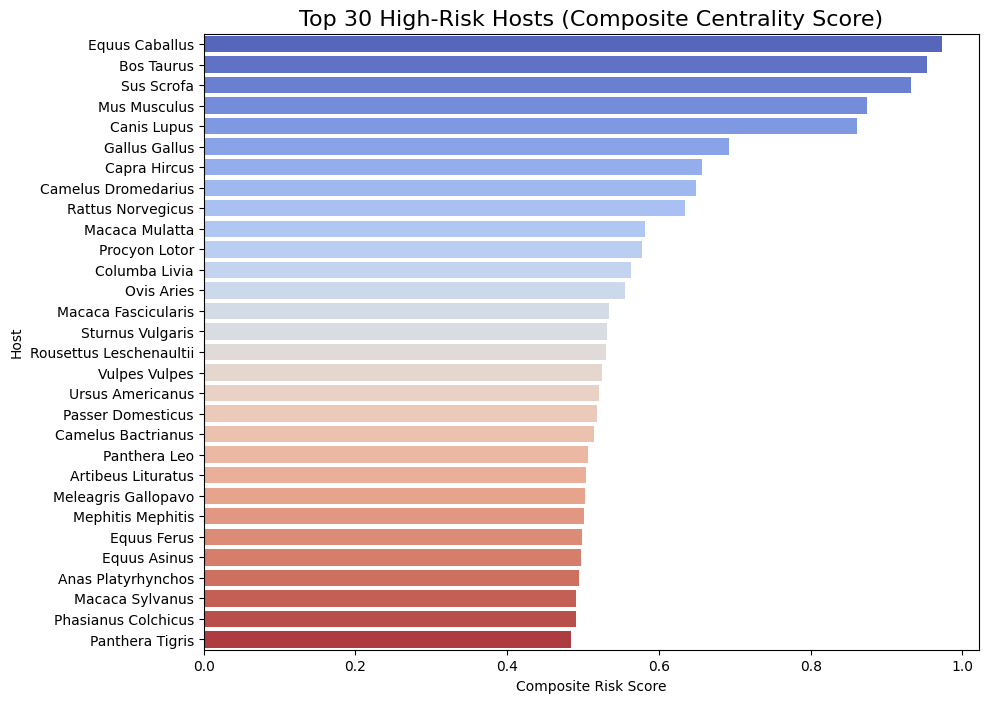

In [29]:
top_30 = ranked_hosts_df.head(30)

plt.figure(figsize=(10, 8))
sns.barplot(
    y=top_30['Host'], 
    x=top_30['CompositeRiskScore'], 
    palette='coolwarm', orient='h'
)
plt.title('Top 30 High-Risk Hosts (Composite Centrality Score)', fontsize=16)
plt.xlabel('Composite Risk Score')
plt.ylabel('Host')
plt.show()
